# Dimensionality Reduction and Projection on CellMeSH

## 1. Getting the CellMeSH matrix

In [1]:
import cellmesh
import matplotlib.pyplot as plt
import numpy as np

In [2]:
subset_cell_ids = cellmesh.get_all_cell_id_names(include_cell_components=False,
                                                include_cell_lines=False,
                                                include_chromosomes=False)
human_genes = np.array(cellmesh.get_all_genes(species='human'))
genes_to_index = {x: i for i, x in enumerate(human_genes)}
cell_ids_to_index = {x[0]: i for i, x in enumerate(subset_cell_ids)}

In [69]:
def gene_list_to_array(gene_list):
    array = np.zeros(len(genes_to_index))
    for gene in gene_list:
        if gene.upper() in genes_to_index:
            array[genes_to_index[gene.upper()]] = 1
    return array

In [3]:
cellmesh_array = np.zeros((len(subset_cell_ids), len(human_genes)))

In [4]:
cellmesh_array.shape

(292, 20138)

In [5]:
cell_tfidf_counts = []
for cell_id, cell_name in subset_cell_ids:
    gene_counts = cellmesh.get_cell_genes_pmids(cell_id, species='human',
                                                      threshold=0, use_tfidf=True,
                                                      return_count=True)
    for gene_name, gene_id, gene_tfidf in gene_counts:
        cellmesh_array[cell_ids_to_index[cell_id], genes_to_index[gene_name]] = gene_tfidf

In [27]:
cellmesh_array_normed = cellmesh_array/(cellmesh_array.sum(1, keepdims=True)+1e-10)

In [6]:
from sklearn.decomposition import PCA

In [35]:
pca = PCA(n_components=3)
data_pca = pca.fit_transform(cellmesh_array)

In [36]:
data_pca.shape

(292, 3)

In [51]:
from sklearn.neighbors import BallTree
nn = BallTree(data_pca, leaf_size=10)

In [62]:
def nearest_neighbor_search(gene_list):
    query = gene_list_to_array(gene_list)
    point = np.dot(pca.components_, query).reshape(1, -1)
    dist, ind = nn.query(point, k=5)
    dist = dist[0]
    ind = ind[0]
    return [subset_cell_ids[x] for x in ind]

In [37]:
import matplotlib.pyplot as plt

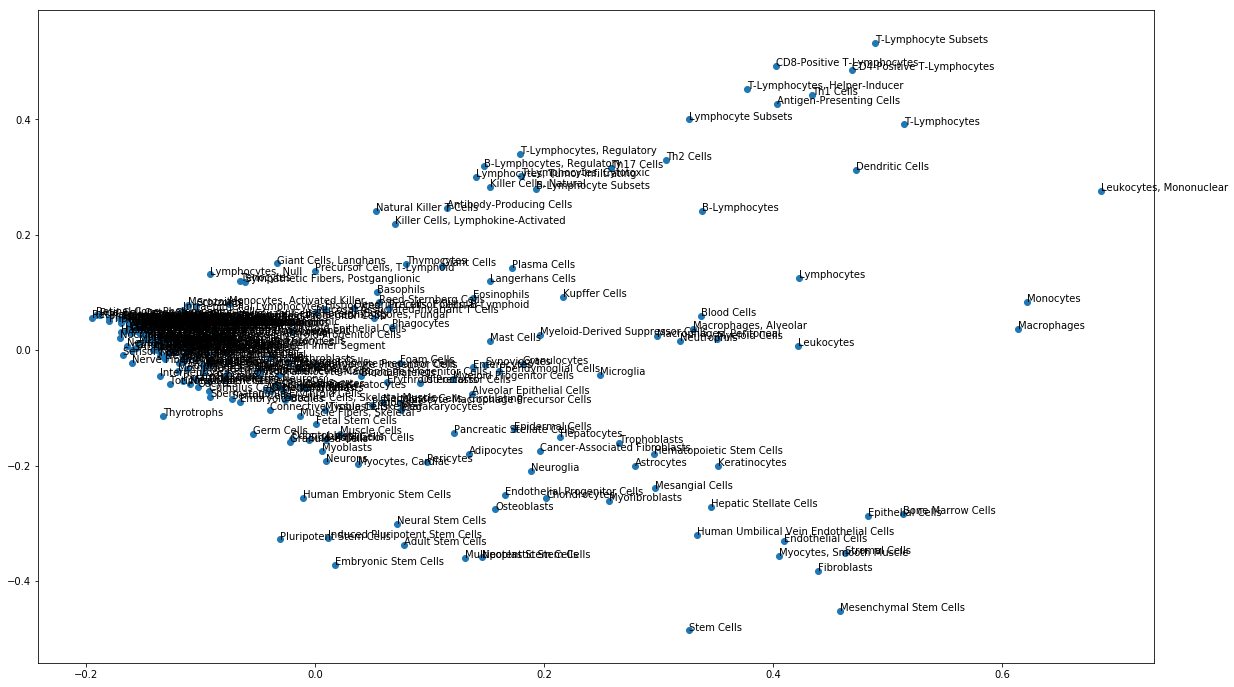

In [38]:
fig, ax = plt.subplots(figsize=(20, 12))
ax.scatter(data_pca[:,0], data_pca[:,1])
for i, c in enumerate(subset_cell_ids):
    ax.annotate(c[1], (data_pca[i,0], data_pca[i,1]))

In [39]:
import plotly
import plotly.graph_objects as go


In [40]:
cell_names = np.array([x[1] for x in subset_cell_ids])

In [41]:
fig = go.Figure(data=go.Scatter(x=data_pca[:,2], y=data_pca[:,1], mode='markers', text=cell_names))
fig.show()

In [42]:
pca.components_.shape

(3, 20138)

In [43]:
query = gene_list_to_array("""GNLY
GZMB
NKG7
FGFBP2
FCGR3A
GZMH
KLRF1
KLRD1
CCL4
CLIC3
PRF1
KLRC1
CST7
GZMA
SPON2
XCL2
CD160
PRSS23
CCL5
S1PR5""".split())

In [47]:
point = np.dot(pca.components_, query)

Text(0.23916,0.241268,'QUERY')

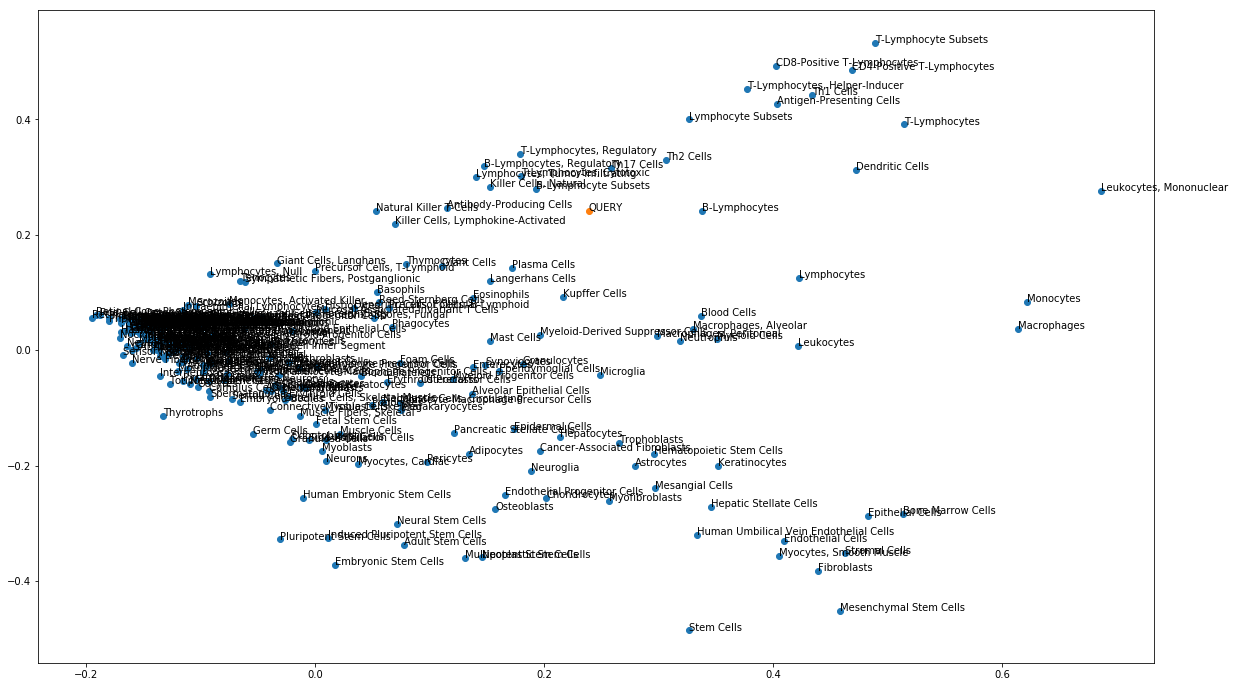

In [50]:
fig, ax = plt.subplots(figsize=(20, 12))
ax.scatter(data_pca[:,0], data_pca[:,1])
for i, c in enumerate(subset_cell_ids):
    ax.annotate(c[1], (data_pca[i,0], data_pca[i,1]))
ax.scatter([point[0]], [point[1]])
ax.annotate('QUERY', (point[0], point[1]))

In [60]:
# NK cells
gene_list = """GNLY
GZMB
NKG7
FGFBP2
FCGR3A
GZMH
KLRF1
KLRD1
CCL4
CLIC3
PRF1
KLRC1
CST7
GZMA
SPON2
XCL2
CD160
PRSS23
CCL5
S1PR5""".split()

In [63]:
nearest_neighbor_search(gene_list)

[('D016175', 'B-Lymphocyte Subsets'),
 ('D058504', 'Th17 Cells'),
 ('D013602', 'T-Lymphocytes, Cytotoxic'),
 ('D007694', 'Killer Cells, Natural'),
 ('D001402', 'B-Lymphocytes')]

In [75]:
# b cells
gene_list_2 = """TCL1A
LINC00926
MS4A1
FCER2
CD79A
VPREB3
IGLL5
BLK
BANK1
CD79B
HLA-DOB
SPIB
CD19
FCRL1
RP5-887A10.1
ARHGAP24
CD22
FCRLA
AC079767.4
PNOC""".split()

In [76]:
nearest_neighbor_search(gene_list_2)

[('D015726', 'Giant Cells'),
 ('D060168', 'Thymocytes'),
 ('D010950', 'Plasma Cells'),
 ('D054448', 'Precursor Cells, B-Lymphoid'),
 ('D016539', 'Reed-Sternberg Cells')]

In [77]:
# monocytes
gene_list_3 = """
FCN1
CD14
CFD
TMEM176B
S100A8
S100A9
CST3
LGALS2
SERPINA1
TMEM176A
LYZ
MS4A6A
IGSF6
IFI30
G0S2
TYMP
CPVL
FPR1
ASGR1
CSF3R""".split()

In [78]:
nearest_neighbor_search(gene_list_3)

[('D000070918', 'Synoviocytes'),
 ('D006098', 'Granulocytes'),
 ('D063928', 'Ependymoglial Cells'),
 ('D020895', 'Enterocytes'),
 ('D008407', 'Mast Cells')]

## Querying with hierarchy